In [24]:
from tensorflow.keras.models import load_model

# loaded_model = load_model('saved_models/NVspin_SimpleRNN_model.h5')
# loaded_model = load_model('saved_models/NVspin_LSTM_model.h5')
loaded_model = load_model('saved_models/NVspin_GRU_model.h5')

In [25]:
import numpy as np
import random
from math import *
import cmath
from scipy.linalg import expm, fractional_matrix_power

#########################################################################

# pauli matrix 
sx = np.array([[0,  1],     [1, 0]])
sy = np.array([[0, -1j],   [1j, 0]])
sz = np.array([[1, 0],     [0, -1]])
s0 = np.array([[1, 0],      [0, 1]])

# parameters(detuning factor)
v0 = 0.02           # Arbitrary settings, Actual speed : 0.04rad/μs
d0 = 0.15           # Arbitrary settings, Actual speed : 0.30rad/μs
dt = 2.6 


# unitary operator
def unitary(dt, choice):
    
    # Select x,y-rotation direction.
    # [stay, +x, -x, +y, -y]
    choice_list = [0, 1, -1, 1, -1] 
    
    if choice < 3:
        # if choice = 0 ... only d0*sz
        Ham = (d0*sz+v0*choice_list[choice]*sx)
    else:
        Ham = (d0*sz+v0*choice_list[choice]*sy)

    # Creating a Unitary Operator for each of the four sections by Hamiltonian
    eigvals = np.linalg.eigh(Ham)[0]
    eigvecs = 1*np.linalg.eigh(Ham)[1]
    E = np.diag(eigvals)
    U_H = eigvecs.conj().T
    U_e = U_H.conj().T @ expm(-1j*E*dt) @ U_H
    
    return U_e


#########################################################################

# x-rotation operater
def Rx(theta):
    return np.matrix([  [cos(theta/2),    -1j*sin(theta/2)],
                        [-1j*sin(theta/2),    cos(theta/2)]])

# z-rotation operater
# Do not use Rz. Control by rotation only by Hamiltonian.
def Rz(phi): 
    return np.matrix([  [cos(phi/2)-1j*sin(phi/2),  0],
                        [0,  cos(phi/2)+1j*sin(phi/2)]])

# Calculating the Fidelity
def state_fidelity(rho_1, rho_2): 
    
    # rho_1(current state), rho_2(target state)
    # Calculate the fidelity after checking the dimensions of the two states.
    
    if np.shape(rho_1) != np.shape(rho_2):
            print("Dimensions of two states do not match.")
            return 0
    else:
        sqrt_rho_1 = fractional_matrix_power(rho_1, 1 / 2)
        fidelity = np.trace(fractional_matrix_power(sqrt_rho_1 @ rho_2 @ sqrt_rho_1, 1 / 2)) ** 2
        return np.real(fidelity)


#########################################################################

init_wave = np.array([[1], [0]])
irho_init = np.kron(init_wave,init_wave.conj().T)


def fidelity(target_theta, target_phi):
    
    target_U = Rz(target_phi) @ Rx(target_theta)
    irho_target = target_U @ irho_init @ target_U.conj().T

    new_theta = np.array(target_theta).reshape(-1, 1)
    new_phi = np.array(target_phi).reshape(-1, 1)
    predicted_sequence = loaded_model.predict([new_theta, new_phi])

    predicted_sequence_indices = np.argmax(predicted_sequence, axis=-1)

    Uni = s0
    U_0 = unitary(dt, 0)
    U_1 = unitary(dt, 1)
    U_2 = unitary(dt, 2)
    U_3 = unitary(dt, 3)
    U_4 = unitary(dt, 4)
    
    pulse_list = [U_0, U_1, U_2, U_3, U_4]
    
    for i in predicted_sequence_indices[0]:
        Uni = pulse_list[i] @ Uni

    irho_final = Uni @ irho_init @ Uni.conj().T
    
    F = (state_fidelity(irho_final,irho_target))
    
    return  F

In [26]:
import pandas as pd

# 데이터 불러오기
data = pd.read_csv("data_results/NVspin_GRU_data_results.csv")

# theta와 phi 값들을 numpy 배열로 변환
thetas = data['Theta'].to_numpy()
phis = data['Phi'].to_numpy()

sum = 0
iter = len(thetas)
num = 0
fidelities = []
low_fidelities = {'theta':[], 'phi':[], 'fidelity':[]}

# theta와 phi 값들을 반복하며 fidelity 계산
for target_theta, target_phi in zip(thetas, phis):  
     
     temp = fidelity(target_theta, target_phi)
     fidelities.append(temp)
     
     if temp < 0.99:
          low_fidelities['theta'].append(target_theta)
          low_fidelities['phi'].append(target_phi)
          low_fidelities['fidelity'].append(temp)
     
     sum += temp
     
     num += 1
     print(num, "/", iter)

print(sum/iter)

1/1 [==============================] - 0s 293ms/step
1 / 17254
1/1 [==============================] - 0s 26ms/step
2 / 17254
1/1 [==============================] - 0s 21ms/step
3 / 17254
1/1 [==============================] - 0s 19ms/step
4 / 17254
1/1 [==============================] - 0s 21ms/step
5 / 17254
1/1 [==============================] - 0s 20ms/step
6 / 17254
1/1 [==============================] - 0s 27ms/step
7 / 17254
1/1 [==============================] - 0s 22ms/step
8 / 17254
1/1 [==============================] - 0s 22ms/step
9 / 17254
1/1 [==============================] - 0s 20ms/step
10 / 17254
1/1 [==============================] - 0s 20ms/step
11 / 17254
1/1 [==============================] - 0s 28ms/step
12 / 17254
1/1 [==============================] - 0s 60ms/step
13 / 17254
1/1 [==============================] - 0s 21ms/step
14 / 17254
1/1 [==============================] - 0s 22ms/step
15 / 17254
1/1 [==============================] - 0s 21ms/step
16 / 17254


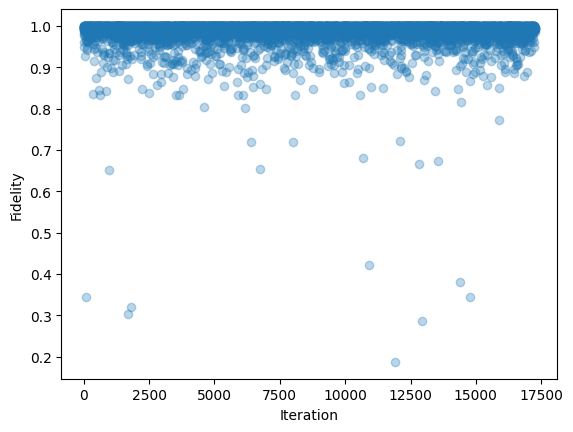

In [27]:
import matplotlib.pyplot as plt

# 그래프 표시
plt.scatter(range(iter), fidelities, alpha=0.3)
plt.xlabel('Iteration')
plt.ylabel('Fidelity')
plt.show()

In [28]:
temp = 0
sum = 0

for i in fidelities:
     temp += 1 
     if i < 0.99:
          sum += 1
          print(temp, i)

print(sum)
print(np.std(fidelities))
print(min(fidelities))

3 0.9879603632591668
10 0.9483308106183673
11 0.9875651749630229
17 0.962152445465263
22 0.9795670967293061
26 0.9786640570280046
27 0.9879017653481095
29 0.9260409522735001
41 0.9883159047594307
48 0.9897948226501528
52 0.9760586264366994
58 0.9865099418293944
71 0.34393293630880556
90 0.9636090261286943
92 0.9806751910815344
103 0.9656586234037225
108 0.9821582800005072
110 0.9871786995331697
111 0.9407682996418424
114 0.9821828385586383
118 0.9878773747983001
122 0.9871130527373799
124 0.9638727570305317
137 0.9456877661315388
141 0.9786687032552355
143 0.9624770873814139
144 0.9883627880714385
151 0.9619246247162597
167 0.9881942638341391
168 0.9735635264724531
171 0.9818514540528277
172 0.989143566859964
185 0.9852995520337554
193 0.9840956743974341
198 0.9867784554145511
204 0.9888386236800757
207 0.9850506297205669
208 0.985292079935249
233 0.9791584442316286
236 0.9846758633591527
239 0.9801760930282751
241 0.972283309651179
254 0.964752139070239
271 0.9890207125549968
278 0.97

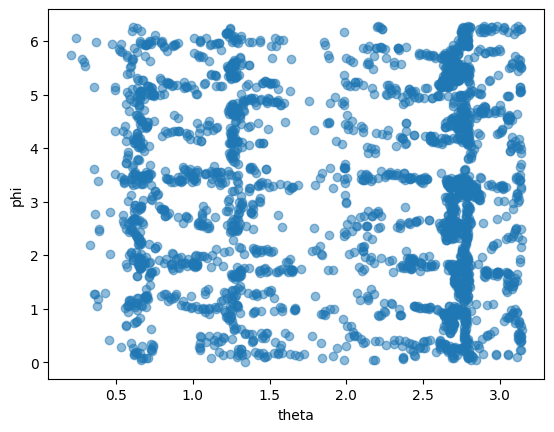

In [29]:
import matplotlib.pyplot as plt

# 그래프 표시
plt.scatter(low_fidelities['theta'], low_fidelities['phi'], alpha=0.5)
plt.xlabel('theta')
plt.ylabel('phi')
plt.show()

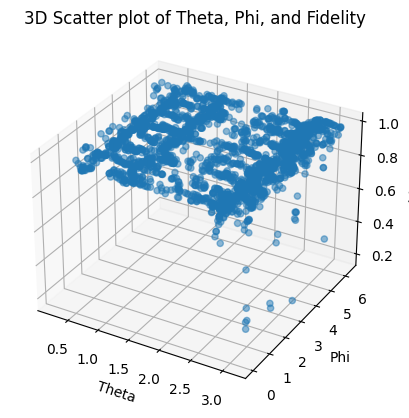

In [30]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 3차원 그래프 생성
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(low_fidelities['theta'], low_fidelities['phi'], low_fidelities['fidelity'], alpha=0.5)
ax.set_xlabel('Theta')
ax.set_ylabel('Phi')
ax.set_zlabel('Fidelity')
plt.title('3D Scatter plot of Theta, Phi, and Fidelity')
plt.show()
